In [ ]:
# Import the library to mount Google Drive
from google.colab import drive

# Mount the Google Drive at /content/drive
drive.mount('/content/drive')

Mounted at /content/drive


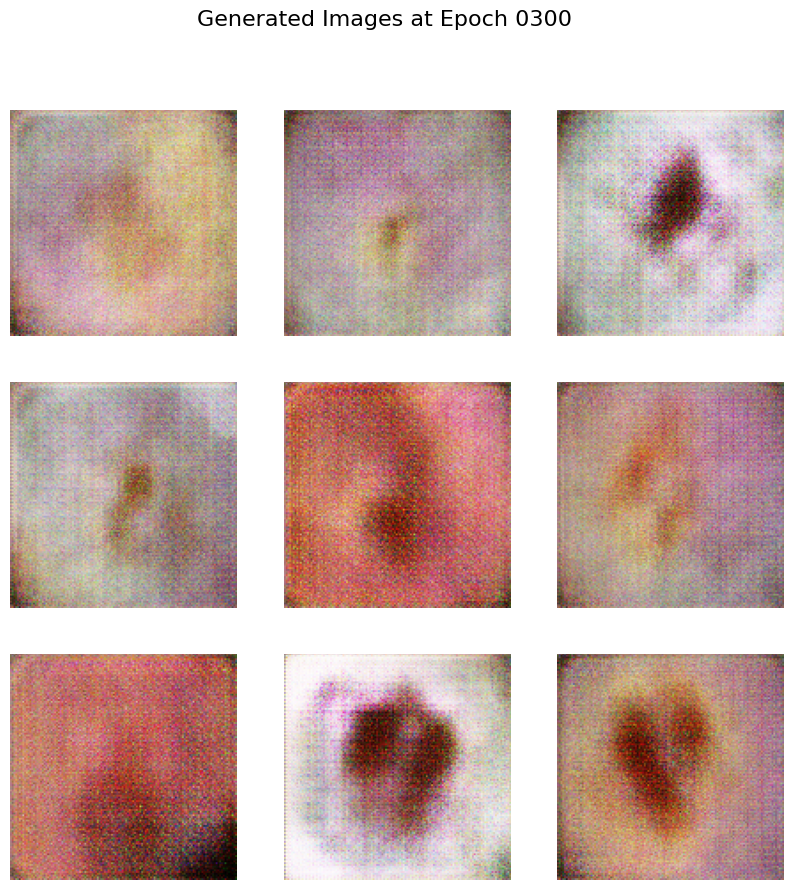

Training finished.
Plotting training loss history...


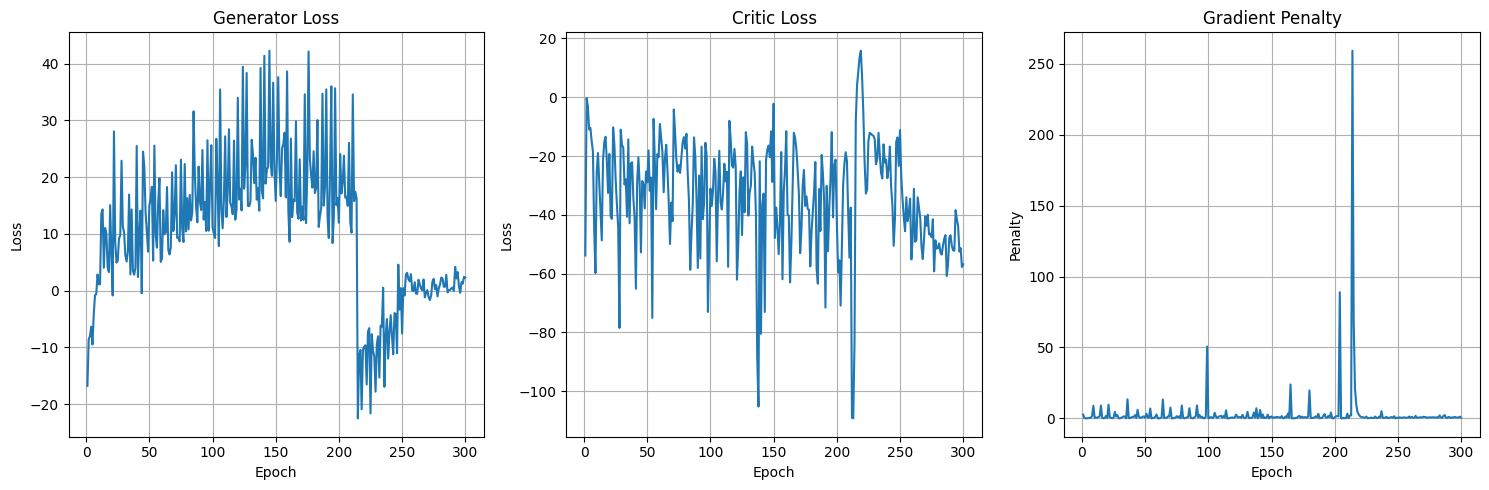

In [ ]:
# Import the library to mount Google Drive
from google.colab import drive

try:
    drive.mount('/content/drive', force_remount=True) # Try force remount first
    print("Google Drive mounted successfully (force remount).")
except Exception as e:
    print(f"Force remount failed: {e}. Attempting standard mount.")
    try:
        drive.mount('/content/drive')
        print("Google Drive mounted successfully (standard mount).")
    except Exception as e_std:
        print(f"Standard mount also failed: {e_std}. Please mount manually.")


# --- Imports ---
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, Model
from IPython import display
from typing import Tuple, Optional # Import for type hints

print(f"TensorFlow version: {tf.__version__}")

# Enable mixed precision for potentially faster training (Optional, requires compatible hardware)
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

IMAGE_SIZE = [128, 128] # Image dimensions for GAN training
BATCH_SIZE = 64          # Batch size
EPOCHS = 300             # Number of training epochs
NOISE_DIM = 128          # Dimension of the latent noise vector
NUM_EXAMPLES_TO_GENERATE = 9 # Number of example images to generate during training

# WGAN-GP specific parameters
CRITIC_UPDATES = 7  # Number of discriminator updates per generator update
LAMBDA_GP = 10.0    # Coefficient for the gradient penalty

# Learning rate schedule - Adjusted schedule
LEARNING_RATE_SCHEDULE = {
    'initial_lr': 1e-4,
    'mid_lr': 5e-5,
    'final_lr': 1e-5,
    'mid_epoch': 150, # Epoch to start using mid_lr
    'final_epoch': 250 # Epoch to start using final_lr
}

# Paths (Update if your dataset path is different)
BASE_DIR = '/content/drive/MyDrive/Colab Notebooks/Skin Cancer Dataset'
image_dir = os.path.join(BASE_DIR, 'jpeg/train/') # Directory containing the image files
train_csv_path = os.path.join(BASE_DIR, 'train.csv') # CSV with image names and targets

# Directory to store generated images and checkpoints
GENERATED_IMAGES_DIR = os.path.join(BASE_DIR, 'generated_images_cwgan') # New directory for cWGAN images
CHECKPOINT_DIR = os.path.join(BASE_DIR, 'training_checkpoints_cwgan')   # New directory for cWGAN checkpoints

# Ensure directories exist
os.makedirs(GENERATED_IMAGES_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print(f"Generated images will be saved to: {GENERATED_IMAGES_DIR}")
print(f"Checkpoints will be saved to: {CHECKPOINT_DIR}")

# Seed for visualization (Defined globally)
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])


# --- Data Loading and Preprocessing ---
print("\nLoading and preparing data...")
try:
    train_df = pd.read_csv(train_csv_path)
    # Filter for malignant samples only for GAN training
    malignant_df = train_df[train_df["target"] == 1].copy()
    print(f"Loaded {len(malignant_df)} malignant samples for GAN training.")
    if len(malignant_df) == 0:
        raise ValueError("No malignant samples found with target == 1. Check 'target' column and CSV path.")
except FileNotFoundError:
    print(f"Error: train.csv not found at {train_csv_path}. Please verify the path.")
    # Exit if essential file is not found
    exit()
except Exception as e:
    print(f"An error occurred loading or processing the CSV: {e}")
    # Exit on other loading errors
    exit()

# Check if 'image_name' column exists
if 'image_name' not in malignant_df.columns:
    print("Error: 'image_name' column not found in the CSV. This column is needed to find image files.")
    exit()


def preprocess_images(image_names, img_dir, img_size):
    """Loads and preprocesses images."""
    images = []
    loaded_count = 0
    skipped_count = 0
    total_images = len(image_names)

    print(f"Attempting to load {total_images} images from {img_dir}")

    for i, img_name in enumerate(malignant_df['image_name'].values):
        img_path = os.path.join(image_dir, str(img_name) + '.jpg') # Assuming JPG format
        if not os.path.exists(img_path):
            # print(f"Warning: Skipping image {img_name}.jpg, file not found at {img_path}")
            skipped_count += 1
            continue # Skip this image and continue to the next

        try:
            # Load and resize image
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
            # Convert image to a numpy array
            img = tf.keras.preprocessing.image.img_to_array(img)
            # Scale pixel values to the range [-1, 1] for GANs
            img = (img / 127.5) - 1.0
            images.append(img)
            loaded_count += 1

            # Print progress periodically
            if (loaded_count + skipped_count) % 1000 == 0:
                 print(f"Processed {loaded_count + skipped_count}/{total_images} images. Loaded: {loaded_count}, Skipped: {skipped_count}")

        except Exception as e:
            print(f"Warning: Skipping image {img_name}. Error processing: {e}")
            skipped_count += 1

    print(f"Finished loading images. Loaded: {loaded_count}, Skipped: {skipped_count}")


    if not images:
        print("Error: No images were successfully loaded. Check image paths, integrity, and format.")
        return np.array([]) # Return empty array if no images loaded

    # Convert list of images to a numpy array
    try:
        return np.array(images, dtype=np.float32)
    except Exception as e:
        print(f"Error converting image list to numpy array: {e}")
        return np.array([])


# Load and preprocess malignant images
malignant_images = preprocess_images(malignant_df['image_name'].values, image_dir, IMAGE_SIZE)

# Also get labels (all 1s for malignant training)
malignant_labels = np.ones(len(malignant_images), dtype=np.int32)


if malignant_images.shape[0] == 0:
    print("Exiting script: No malignant images were loaded successfully for GAN training.")
    exit() # Exit if no images are available for training

print(f"Malignant image array shape: {malignant_images.shape}")
print(f"Malignant label array shape: {malignant_labels.shape}")


# Safe display function to handle image scaling [-1, 1] to [0, 1]
def safe_display_image(img_tensor):
    """Displays an image tensor scaled from [-1, 1] to [0, 1]."""
    img = img_tensor.numpy() if tf.is_tensor(img_tensor) else img_tensor
    img = (img + 1.0) / 2.0 # Denormalize from [-1, 1] to [0, 1]
    img = np.clip(img, 0, 1) # Clip to ensure valid pixel range
    plt.imshow(img)
    plt.axis("off")

# Show sample preprocessed real images
def display_original_images(img_array, n=9, title="Sample Preprocessed Real Images"):
    """Displays a grid of sample images."""
    plt.figure(figsize=(7, 7))
    plt.suptitle(title, fontsize=16)
    for i in range(min(n, len(img_array))):
        plt.subplot(3, 3, i + 1)
        safe_display_image(img_array[i])
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to prevent suptitle overlap
    plt.show()
    plt.close()

print("\nDisplaying sample preprocessed real malignant images:")
display_original_images(malignant_images)


# --- Create TF Dataset with improved shuffling and prefetching ---
# Create dataset from images and labels
if malignant_images.shape[0] > 0:
    BUFFER_SIZE = len(malignant_images) # Use the number of loaded images
    train_dataset = tf.data.Dataset.from_tensor_slices((malignant_images, malignant_labels))\
        .shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)\
        .batch(BATCH_SIZE, drop_remainder=True)\
        .prefetch(tf.data.AUTOTUNE)
    print(f"TF Dataset created. Number of batches per epoch: {len(list(train_dataset))}")
else:
    print("Cannot create dataset as no images were loaded.")
    train_dataset = None # Explicitly set to None


# --- Conditional Models (Generator and Discriminator)
class ConditionalGenerator(tf.keras.Model):
    def __init__(self, noise_dim, num_classes=2):
        super(ConditionalGenerator, self).__init__()
        self.noise_dim = noise_dim
        self.num_classes = num_classes # Although it only uses class 1 here, keep general

        # Embedding for the class label
        self.label_embedding = layers.Embedding(num_classes, noise_dim) # Embed label to noise_dim

        # Initial dense layer for 4x4 image foundation - Input is combined noise + embedded label
        self.dense = layers.Dense(4 * 4 * 1024, use_bias=False, input_shape=(noise_dim * 2,)) # Combine noise and label embedding
        self.bn1 = layers.BatchNormalization()
        self.relu1 = layers.ReLU()
        self.reshape = layers.Reshape((4, 4, 1024))

        # Upsampling layers
        self.convt1 = layers.Conv2DTranspose(512, (5,5), strides=(2,2), padding='same', use_bias=False) # 8x8
        self.bn2 = layers.BatchNormalization()
        self.relu2 = layers.ReLU()

        self.convt2 = layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding='same', use_bias=False) # 16x16
        self.bn3 = layers.BatchNormalization()
        self.relu3 = layers.ReLU()

        self.convt3 = layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False) # 32x32
        self.bn4 = layers.BatchNormalization()
        self.relu4 = layers.ReLU()

        self.convt4 = layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False) # 64x64
        self.bn5 = layers.BatchNormalization()
        self.relu5 = layers.ReLU()

        # Output layer (128x128)
        self.convt5 = layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', activation='tanh') # Output: [-1, 1]

    def call(self, inputs, training=False):
        noise, labels = inputs # Expecting a tuple (noise, labels)

        # Embed labels and flatten
        embedded_labels = self.label_embedding(labels)
        embedded_labels = tf.reshape(embedded_labels, [-1, self.noise_dim]) # Ensure shape matches noise

        # Concatenate noise and embedded labels
        combined_input = tf.concat([noise, embedded_labels], axis=-1)

        # Process combined input
        x = self.dense(combined_input)
        x = self.bn1(x, training=training)
        x = self.relu1(x)
        x = self.reshape(x)

        # Upsampling
        x = self.convt1(x)
        x = self.bn2(x, training=training)
        x = self.relu2(x)

        x = self.convt2(x)
        x = self.bn3(x, training=training)
        x = self.relu3(x)

        x = self.convt3(x)
        x = self.bn4(x, training=training)
        x = self.relu4(x)

        x = self.convt4(x)
        x = self.bn5(x, training=training)
        x = self.relu5(x)

        output = self.convt5(x)
        return output

# Conditional Discriminator Model using Model Subclassing
class ConditionalDiscriminator(tf.keras.Model):
    def __init__(self, num_classes=2):
        super(ConditionalDiscriminator, self).__init__()
        self.num_classes = num_classes

        # Embedding for the class label
        self.label_embedding = layers.Embedding(num_classes, np.prod(IMAGE_SIZE)) # Embed label to match image size flattened

        # Initial convolution layer - Input image + embedded label
        # Concatenate image and spatially replicated label
        self.conv1 = layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3 + 1]) # Input channels + 1 for label
        self.lrelu1 = layers.LeakyReLU(0.2)
        self.dropout1 = layers.Dropout(0.3)

        # Downsampling layers
        self.conv2 = layers.Conv2D(128, (5,5), strides=(2,2), padding='same') # 32x32
        self.bn2 = layers.BatchNormalization()
        self.lrelu2 = layers.LeakyReLU(0.2)
        self.dropout2 = layers.Dropout(0.3)

        self.conv3 = layers.Conv2D(256, (5,5), strides=(2,2), padding='same') # 16x16
        self.bn3 = layers.BatchNormalization()
        self.lrelu3 = layers.LeakyReLU(0.2)
        self.dropout3 = layers.Dropout(0.3)

        self.conv4 = layers.Conv2D(512, (5,5), strides=(2,2), padding='same') # 8x8
        self.bn4 = layers.BatchNormalization()
        self.lrelu4 = layers.LeakyReLU(0.2)
        self.dropout4 = layers.Dropout(0.3)

        self.conv5 = layers.Conv2D(1024, (5,5), strides=(2,2), padding='same') # 4x4
        self.bn5 = layers.BatchNormalization()
        self.lrelu5 = layers.LeakyReLU(0.2)
        self.dropout5 = layers.Dropout(0.3)

        # Output layers
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1) # Linear output for WGAN-GP

    def call(self, inputs, training=False):
        images, labels = inputs # Expecting a tuple (images, labels)

        # Embed labels and reshape/tile to match image spatial dimensions
        embedded_labels = self.label_embedding(labels)
        # Reshape embedded labels to match image spatial size, add channel dim
        embedded_labels = tf.reshape(embedded_labels, [-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 1])
        if labels.shape.rank == 1:
             labels = tf.expand_dims(labels, axis=-1) # Shape [batch_size, 1]

        # Cast labels to float32 and tile to match image spatial dimensions + batch size
        tiled_labels = tf.cast(labels, tf.float32)
        tiled_labels = tf.tile(tiled_labels, [1, IMAGE_SIZE[0] * IMAGE_SIZE[1]])
        tiled_labels = tf.reshape(tiled_labels, [-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 1])

        # Concatenate image and tiled labels along the channel dimension
        combined_input = tf.concat([images, tiled_labels], axis=-1)
        # Downsampling
        x = self.conv1(combined_input)
        x = self.lrelu1(x)
        x = self.dropout1(x, training=training)

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.lrelu2(x)
        x = self.dropout2(x, training=training)

        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = self.lrelu3(x)
        x = self.dropout3(x, training=training)

        x = self.conv4(x)
        x = self.bn4(x, training=training)
        x = self.lrelu4(x)
        x = self.dropout4(x, training=training)

        x = self.conv5(x)
        x = self.bn5(x, training=training)
        x = self.lrelu5(x)
        x = self.dropout5(x, training=training)

        x = self.flatten(x)
        output = self.dense(x)
        return output




# Instantiate conditional models
conditional_generator = ConditionalGenerator(NOISE_DIM, num_classes=2)
conditional_discriminator = ConditionalDiscriminator(num_classes=2)

print("\nConditional Generator and Discriminator models built.")




# --- WGAN-GP Losses ---
# Critic loss: max E[fake] - E[real]
def critic_loss_fn(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

# Generator loss: min E[fake] -> max E[fake] -> -E[fake]
def generator_loss_fn(fake_output):
    return -tf.reduce_mean(fake_output)

# Gradient Penalty
@tf.function
def gradient_penalty_fn(critic_model, real_images, fake_images, labels):
    """Calculates the gradient penalty for cWGAN-GP."""
    batch_size = tf.shape(real_images)[0]
    # Sample a random point on the line between real and fake samples
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    interpolated = alpha * real_images + (1.0 - alpha) * fake_images

    # Compute gradient of the critic's output with respect to interpolated samples
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        # Pass interpolated images AND labels to the critic
        pred = critic_model((interpolated, labels), training=True)
    grads = gp_tape.gradient(pred, [interpolated])[0]

    # Compute the L2 norm of the gradients
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]) + 1e-12) # Add epsilon for stability

    # Compute the gradient penalty
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp



# Using Adam with specific beta values for WGAN-GP
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_SCHEDULE['initial_lr'], beta_1=0.0, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_SCHEDULE['initial_lr'], beta_1=0.0, beta_2=0.9)


# --- Checkpoints ---
checkpoint_prefix = os.path.join(CHECKPOINT_DIR, "ckpt")
checkpoint = tf.train.Checkpoint(generator=conditional_generator, # Use conditional generator
                                 discriminator=conditional_discriminator, # Use conditional discriminator
                                 generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 epoch=tf.Variable(0))


# --- Training Step ---
@tf.function
def train_step(images_batch, labels_batch): # Expecting images and labels
    """Performs one training step for the cWGAN-GP."""
    current_batch_size = tf.shape(images_batch)[0]
    noise = tf.random.normal([current_batch_size, NOISE_DIM])
    # For this specific case (training only on malignant), labels_batch will be all 1s
    # Pass noise and labels to the generator
    generator_inputs = (noise, labels_batch)


    # Train Discriminator
    with tf.GradientTape() as critic_tape:
        # Generate fake images with conditioning
        fake_images = conditional_generator(generator_inputs, training=True)

        # Get discriminator outputs for real and fake images, with conditioning
        real_output = conditional_discriminator((images_batch, labels_batch), training=True)
        fake_output = conditional_discriminator((fake_images, labels_batch), training=True) # Pass labels with fake images

        # Compute losses
        c_loss = critic_loss_fn(real_output, fake_output)
        # Compute gradient penalty with labels
        gp = gradient_penalty_fn(conditional_discriminator, images_batch, fake_images, labels_batch)
        total_c_loss = c_loss + LAMBDA_GP * gp

    # Compute and apply gradients for discriminator
    grads_critic = critic_tape.gradient(total_c_loss, conditional_discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(grads_critic, conditional_discriminator.trainable_variables))

    # Train Generator (only update generator after N critic updates)
    # Use tf.equal for graph mode compatibility
    if tf.equal(discriminator_optimizer.iterations % CRITIC_UPDATES, 0):
        with tf.GradientTape() as gen_tape:
            # Generate fake images again to get gradients for the generator
            # Use the same noise and labels for consistency within this step
            fake_images = conditional_generator(generator_inputs, training=True)
            # Get discriminator output for fake images, with conditioning
            fake_output = conditional_discriminator((fake_images, labels_batch), training=True)
            # Compute generator loss
            g_loss = generator_loss_fn(fake_output)

        # Compute and apply gradients for generator
        grads_gen = gen_tape.gradient(g_loss, conditional_generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(grads_gen, conditional_generator.trainable_variables))
    else:
        # If generator is not trained, return zero loss for it for this step
        g_loss = tf.constant(0.0)


    # Return losses for logging
    return g_loss, c_loss, gp # Return gp before multiplying by lambda for clearer monitoring


# --- Image Generation and Saving ---
# Modify generate_and_save_images to accept labels for generation
def generate_and_save_images(model, epoch, test_noise, test_labels, output_dir):
    """Generates and saves example images from the conditional generator."""
    # Ensure the generator is not in training mode
    predictions = model((test_noise, test_labels), training=False) # Pass noise and labels

    fig = plt.figure(figsize=(10,10))
    plt.suptitle(f"Generated Images at Epoch {epoch:04d}", fontsize=16)

    for i in range(predictions.shape[0]):
        plt.subplot(3, 3, i + 1)
        safe_display_image(predictions[i]) # safe_display_image handles [-1,1] range

    save_path = os.path.join(output_dir, f'image_at_epoch_{epoch:04d}.png')
    plt.savefig(save_path)
    plt.show()
    plt.close(fig)


# --- Training Loop ---
# Modify train function to handle dataset yielding images and labels
def train(dataset, epochs, initial_epoch=0, test_noise=None, test_labels=None): # Added test_noise, test_labels
    """Main training function for the cWGAN-GP."""
    if dataset is None:
        print("Training dataset is not available. Skipping training.")
        return None, None, None # Return empty lists or None

    if test_noise is None or test_labels is None:
        print("Warning: Test noise or labels for image generation not provided. Generating new ones.")
        # Generate new test noise and labels if none are provided
        test_noise = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])
        # Assuming we only generate malignant (class 1) for visualization during this training
        test_labels = tf.ones([NUM_EXAMPLES_TO_GENERATE], dtype=tf.int32)


    print("Starting training loop...")
    g_losses_hist = []
    c_losses_hist = []
    gp_losses_hist = []

    # Check if a checkpoint exists and restore
    latest_checkpoint = tf.train.latest_checkpoint(CHECKPOINT_DIR)
    if latest_checkpoint:
        print(f"Restoring from checkpoint: {latest_checkpoint}")
        # Use expect_partial() if you change model architecture or optimizers
        status = checkpoint.restore(latest_checkpoint)
        try:
            # Attempt to assert that all variables were restored. If not, expect_partial is safer.
            status.assert_consumed()
            initial_epoch = checkpoint.epoch.numpy() # Resume from saved epoch
            print(f"Checkpoint restored successfully. Resuming from epoch {initial_epoch + 1}.")
        except Exception as e:
            print(f"Error restoring checkpoint completely: {e}. Using expect_partial.")
            # If assert_consumed fails, try restoring partially
            status = checkpoint.restore(latest_checkpoint).expect_partial()
            print("Restored partially. Starting epoch counter from 0 for history plotting.")
            initial_epoch = 0 # Reset epoch counter for history if partial restore


    print(f"Entering epoch loop from epoch {initial_epoch + 1}...")
    for epoch in range(initial_epoch, epochs):
        start_time = time.time()
        g_loss_metric = tf.keras.metrics.Mean()
        c_loss_metric = tf.keras.metrics.Mean()
        gp_loss_metric = tf.keras.metrics.Mean()

        # Update learning rate according to schedule
        current_lr_val = generator_optimizer.learning_rate.numpy()
        new_lr_val = LEARNING_RATE_SCHEDULE['initial_lr'] # Default to initial

        if epoch >= LEARNING_RATE_SCHEDULE['mid_epoch'] and epoch < LEARNING_RATE_SCHEDULE['final_epoch']:
             new_lr_val = LEARNING_RATE_SCHEDULE['mid_lr']
        elif epoch >= LEARNING_RATE_SCHEDULE['final_epoch']:
             new_lr_val = LEARNING_RATE_SCHEDULE['final_lr']

        # Only assign if learning rate changes to avoid unnecessary operations
        if abs(new_lr_val - current_lr_val) > 1e-8: # Check for significant change
            generator_optimizer.learning_rate.assign(new_lr_val)
            discriminator_optimizer.learning_rate.assign(new_lr_val)
            print(f"Epoch {epoch+1}: Learning rate updated to {new_lr_val:.1e}")


        # Iterate over the dataset which yields images and labels
        print(f"Epoch {epoch+1}/{epochs} starting. Batch iteration...")
        for i, (images_batch, labels_batch) in enumerate(dataset): # Get images and labels from dataset
             step_g_loss, step_c_loss, step_gp_loss = train_step(images_batch, labels_batch) # Pass images and labels to train_step
             g_loss_metric.update_state(step_g_loss)
             c_loss_metric.update_state(step_c_loss)
             gp_loss_metric.update_state(step_gp_loss)

             # Optional: Print batch progress
             # if (i + 1) % 50 == 0:
             #    print(f"  Epoch {epoch+1}, Batch {i+1}/{len(dataset)} - G Loss: {g_loss_metric.result():.4f}, C Loss: {c_loss_metric.result():.4f}, GP Loss: {gp_loss_metric.result():.4f}")

        print(f"Epoch {epoch+1}: Finished dataset iteration.")

        epoch_g_loss = g_loss_metric.result().numpy()
        epoch_c_loss = c_loss_metric.result().numpy()
        epoch_gp_loss = gp_loss_metric.result().numpy() # This is GP, not LAMBDA_GP * GP

        g_losses_hist.append(epoch_g_loss)
        c_losses_hist.append(epoch_c_loss)
        # Append total critic loss (C_loss + LAMBDA_GP * GP) or just GP?
        # Let's append gp_loss_metric.result() which is just the GP term
        gp_losses_hist.append(epoch_gp_loss)


        # Generate and save images for visualization using the test seed and labels
        display.clear_output(wait=True) # Clear previous output in Colab
        # Pass test_noise and test_labels to generate_and_save_images
        generate_and_save_images(conditional_generator, epoch + 1, test_noise, test_labels, output_dir=GENERATED_IMAGES_DIR)

        # Save checkpoint
        if (epoch + 1) % 15 == 0: # Save checkpoint every 15 epochs
            checkpoint.epoch.assign(epoch) # Save current epoch
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f"Checkpoint saved for epoch {epoch + 1} at {checkpoint_prefix}.")

        # Print epoch summary
        print(f"Epoch {epoch+1} completed in {time.time() - start_time:.2f} sec")
        print(f"  G_loss: {epoch_g_loss:.4f}, C_loss: {epoch_c_loss:.4f}, GP: {epoch_gp_loss:.4f}")
        print(f"  Current learning rate: {generator_optimizer.learning_rate.numpy():.1e}")


    # Final image generation and plotting after all epochs
    display.clear_output(wait=True)
    # Pass test_noise and test_labels for final generation
    generate_and_save_images(conditional_generator, epochs, test_noise, test_labels, output_dir=GENERATED_IMAGES_DIR)
    print("Training finished.")

    # Plot loss history
    print("Plotting training loss history...")
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    # Adjust x-axis range based on initial_epoch for correct plotting after resuming
    plt.plot(range(initial_epoch + 1, epochs + 1), g_losses_hist)
    plt.title('Generator Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(range(initial_epoch + 1, epochs + 1), c_losses_hist)
    plt.title('Critic Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(range(initial_epoch + 1, epochs + 1), gp_losses_hist)
    plt.title('Gradient Penalty') # Label as Gradient Penalty
    plt.xlabel('Epoch'); plt.ylabel('Penalty'); plt.grid(True)

    plt.tight_layout()
    history_plot_path = os.path.join(GENERATED_IMAGES_DIR, 'training_loss_history_cwgan.png')
    plt.savefig(history_plot_path)
    plt.show()
    plt.close('all')

    return g_losses_hist, c_losses_hist, gp_losses_hist


# --- Main Execution ---
if __name__ == "__main__":
    # Generate a fixed set of test labels for consistent visualization (all 1s for malignant)
    test_labels_for_generation = tf.ones([NUM_EXAMPLES_TO_GENERATE], dtype=tf.int32)

    # Start training, passing the test noise (seed) and test labels
    if 'train_dataset' in locals() and train_dataset is not None:
        g_losses, c_losses, gp_losses = train(
            train_dataset,
            EPOCHS,
            test_noise=seed, # Use the global seed for test noise
            test_labels=test_labels_for_generation # Use the fixed test labels
        )
    else:
        print("Training skipped because the dataset was not created successfully.")


Mounted at /content/drive
Available checkpoint files: ['ckpt-1.data-00000-of-00001', 'ckpt-1.index', 'ckpt-2.data-00000-of-00001', 'ckpt-2.index', 'ckpt-3.data-00000-of-00001', 'ckpt-3.index', 'ckpt-4.data-00000-of-00001', 'ckpt-4.index', 'ckpt-5.data-00000-of-00001', 'ckpt-5.index', 'ckpt-6.data-00000-of-00001', 'ckpt-6.index', 'ckpt-7.data-00000-of-00001', 'ckpt-7.index', 'ckpt-8.data-00000-of-00001', 'ckpt-8.index', 'ckpt-9.data-00000-of-00001', 'ckpt-9.index', 'ckpt-10.data-00000-of-00001', 'ckpt-10.index', 'ckpt-11.data-00000-of-00001', 'ckpt-11.index', 'ckpt-12.data-00000-of-00001', 'ckpt-12.index', 'ckpt-13.data-00000-of-00001', 'ckpt-13.index', 'ckpt-14.data-00000-of-00001', 'ckpt-14.index', 'ckpt-15.data-00000-of-00001', 'ckpt-15.index', 'ckpt-16.data-00000-of-00001', 'ckpt-16.index', 'ckpt-17.data-00000-of-00001', 'ckpt-17.index', 'ckpt-18.data-00000-of-00001', 'ckpt-18.index', 'ckpt-19.data-00000-of-00001', 'ckpt-19.index', 'ckpt-20.data-00000-of-00001', 'ckpt-20.index', 'ch

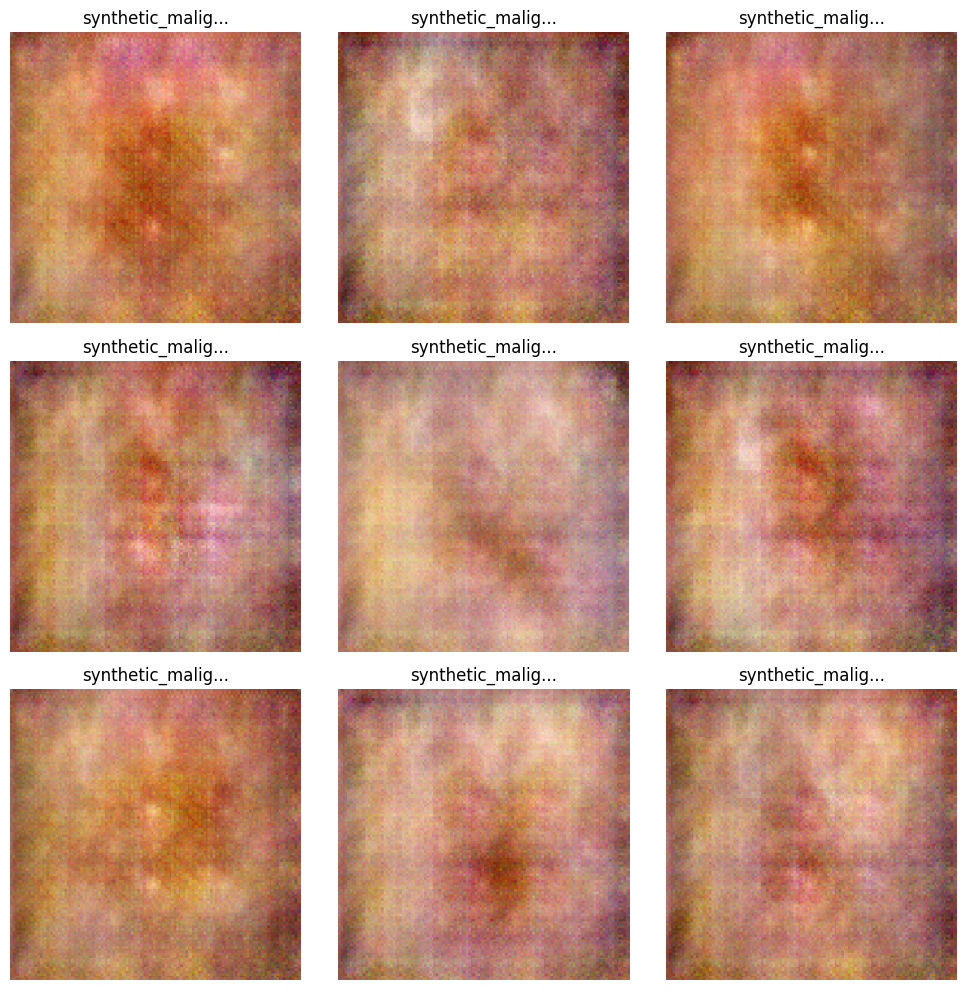

In [ ]:
# 1. Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # Force remount to ensure connection

# 2. Import necessary libraries
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers

# 3. Configuration
# GAN Configuration
NOISE_DIM = 128
BATCH_SIZE_GAN = 32
CHECKPOINT_DIR = '/content/drive/MyDrive/Colab Notebooks/Skin Cancer Dataset/training_checkpoints_user_code_augmented'

# Verify checkpoint directory exists
if not os.path.exists(CHECKPOINT_DIR):
    raise ValueError(f"Checkpoint directory not found: {CHECKPOINT_DIR}")

# List checkpoint files to verify they exist
checkpoint_files = os.listdir(CHECKPOINT_DIR)
print("Available checkpoint files:", checkpoint_files)

# Image Configuration
CLASSIFIER_IMAGE_SIZE = (224, 224)

# Directory Configuration
SYNTHETIC_MALIGNANT_DIR = '/content/drive/MyDrive/Colab Notebooks/Skin Cancer Dataset/synthetic_malignant_images'
os.makedirs(SYNTHETIC_MALIGNANT_DIR, exist_ok=True)

# 4. Define the Generator class (same as in training)
class Generator(tf.keras.Model):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.dense_4x4 = layers.Dense(4 * 4 * 1024, use_bias=False)  # Removed input_shape
        self.bn_4x4 = layers.BatchNormalization()
        self.relu_4x4 = layers.ReLU()
        self.reshape_4x4 = layers.Reshape((4, 4, 1024))
        self.upsample_8x8 = layers.Conv2DTranspose(512, (5,5), strides=(2,2), padding='same', use_bias=False)
        self.bn_8x8 = layers.BatchNormalization()
        self.relu_8x8 = layers.ReLU()
        self.upsample_16x16 = layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding='same', use_bias=False)
        self.bn_16x16 = layers.BatchNormalization()
        self.relu_16x16 = layers.ReLU()
        self.upsample_32x32 = layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False)
        self.bn_32x32 = layers.BatchNormalization()
        self.relu_32x32 = layers.ReLU()
        self.upsample_64x64 = layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False)
        self.bn_64x64 = layers.BatchNormalization()
        self.relu_64x64 = layers.ReLU()
        self.upsample_128x128 = layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', activation='tanh')

    def call(self, inputs, training=False):
        x = self.dense_4x4(inputs)
        x = self.bn_4x4(x, training=training)
        x = self.relu_4x4(x)
        x = self.reshape_4x4(x)
        x = self.upsample_8x8(x)
        x = self.bn_8x8(x, training=training)
        x = self.relu_8x8(x)
        x = self.upsample_16x16(x)
        x = self.bn_16x16(x, training=training)
        x = self.relu_16x16(x)
        x = self.upsample_32x32(x)
        x = self.bn_32x32(x, training=training)
        x = self.relu_32x32(x)
        x = self.upsample_64x64(x)
        x = self.bn_64x64(x, training=training)
        x = self.relu_64x64(x)
        output = self.upsample_128x128(x)
        return output

# 5. Create and load the trained generator
print("Creating generator model...")
generator = Generator(NOISE_DIM)
checkpoint = tf.train.Checkpoint(generator=generator)

# Try to load the latest checkpoint
latest_checkpoint = tf.train.latest_checkpoint(CHECKPOINT_DIR)
if latest_checkpoint is None:
    raise ValueError(f"No checkpoint found in {CHECKPOINT_DIR}")

print(f"Loading checkpoint: {latest_checkpoint}")
try:
    status = checkpoint.restore(latest_checkpoint)
    status.expect_partial()  # Use expect_partial() instead of assert_consumed()
    print("Checkpoint loaded successfully")
except Exception as e:
    print(f"Error loading checkpoint: {e}")
    raise

trained_generator = generator

# 6. Generate synthetic images
NUM_SYNTHETIC_MALIGNANT_IMAGES = 1000

print(f"\nGenerating {NUM_SYNTHETIC_MALIGNANT_IMAGES} synthetic malignant images...")

generated_count = 0
batch_num = 0
while generated_count < NUM_SYNTHETIC_MALIGNANT_IMAGES:
    current_gen_batch_size = min(BATCH_SIZE_GAN, NUM_SYNTHETIC_MALIGNANT_IMAGES - generated_count)
    if current_gen_batch_size <= 0:
        break

    noise = tf.random.normal([current_gen_batch_size, NOISE_DIM])
    try:
        synthetic_images_batch = trained_generator(noise, training=False)
    except Exception as e:
        print(f"Error generating images: {e}")
        raise

    for i in range(synthetic_images_batch.shape[0]):
        if generated_count >= NUM_SYNTHETIC_MALIGNANT_IMAGES:
            break

        img_to_save_normalized = (synthetic_images_batch[i] + 1.0) / 2.0
        img_to_save_uint8 = (img_to_save_normalized.numpy() * 255).astype(np.uint8)

        file_name = f"synthetic_malignant_{generated_count:04d}.png"
        file_path = os.path.join(SYNTHETIC_MALIGNANT_DIR, file_name)
        tf.keras.preprocessing.image.save_img(file_path, img_to_save_uint8)
        generated_count += 1

    batch_num += 1
    print(f"  Generated batch {batch_num}, total images: {generated_count}/{NUM_SYNTHETIC_MALIGNANT_IMAGES}")

print(f"\nFinished generating {generated_count} synthetic malignant images in: {SYNTHETIC_MALIGNANT_DIR}")

# Display sample images
print("\nDisplaying a few sample synthetic malignant images generated for the classifier...")
synthetic_image_files = [os.path.join(SYNTHETIC_MALIGNANT_DIR, f) for f in os.listdir(SYNTHETIC_MALIGNANT_DIR) if f.endswith('.png')]
if synthetic_image_files:
    plt.figure(figsize=(10, 10))
    for i, file_path in enumerate(synthetic_image_files[:9]):
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=CLASSIFIER_IMAGE_SIZE)
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        plt.subplot(3, 3, i + 1)
        plt.imshow(img_array)
        plt.title(os.path.basename(file_path)[:15]+"...")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()
else:
    print("No synthetic images found to display.")

In [ ]:
# 2.1 Prepare Real Data for Classifier

import os
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# =============================
# Clean up TF dataset cache/lockfiles
# =============================
def cleanup_tf_dataset_cache(cache_prefix_pattern="./*_classifier_cache*"):
    """
    Removes TensorFlow dataset cache files and lockfiles matching the pattern to prevent cache collisions.
    """
    deleted_any = False
    for fname in glob.glob(cache_prefix_pattern):
        try:
            os.remove(fname)
            print(f"Deleted cache or lockfile: {fname}")
            deleted_any = True
        except Exception as e:
            print(f"Could not delete {fname}: {e}")
    if not deleted_any:
        print("No TF cache or lockfiles found to delete.")

# Always clean cache before dataset creation
cleanup_tf_dataset_cache()

print("\n--- Phase 2.1: Preparing Real Data for Classifier ---")
try:
    full_train_df = pd.read_csv(TRAIN_CSV_PATH)
    print(f"Loaded {len(full_train_df)} total samples from {TRAIN_CSV_PATH}")
except Exception as e:
    print(f"Error loading {TRAIN_CSV_PATH}: {e}")
    exit()

# Create full image paths and extract labels
full_train_df['image_path'] = full_train_df['image_name'].apply(lambda x: os.path.join(IMAGE_DATA_DIR, str(x) + '.jpg'))
print(f"Initial number of image paths: {len(full_train_df)}")
full_train_df = full_train_df[full_train_df['image_path'].apply(os.path.exists)]
print(f"Found {len(full_train_df)} existing real images for classification training.")

if len(full_train_df) == 0:
    print("Error: No existing image files found based on the CSV and IMAGE_DATA_DIR. Please check paths.")
    exit()

full_train_df = full_train_df[['image_path', 'target']]

# Ensure there's data for both classes
if not (0 in full_train_df['target'].values and 1 in full_train_df['target'].values):
    print("Warning: The dataset for classification ideally should contain samples from both target classes (0 and 1).")
    print(f"Class distribution:\n{full_train_df['target'].value_counts()}")

# Split real data into training and validation sets
real_train_df, real_val_df = train_test_split(
    full_train_df,
    test_size=0.2,
    random_state=42,
    stratify=full_train_df['target'] if (0 in full_train_df['target'].values and 1 in full_train_df['target'].values) else None
)
print(f"Real training samples: {len(real_train_df)}, Real validation samples: {len(real_val_df)}")
if len(real_train_df) > 0:
    print(f"Real training class distribution:\n{real_train_df['target'].value_counts(normalize=True)}")
if len(real_val_df) > 0:
    print(f"Real validation class distribution:\n{real_val_df['target'].value_counts(normalize=True)}")

# tf.data.Dataset creation
def create_classifier_dataset(df, batch_size, shuffle=True, augment=False, cache_file_prefix=None):
    if df.empty:
        print("Warning: Input DataFrame is empty. Returning None for dataset.")
        return None

    image_paths = df['image_path'].values
    labels = df['target'].values.astype(np.float32)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    def parse_and_preprocess_image(image_path, label):
        img_string = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img_string, channels=3)
        img = tf.image.resize(img, CLASSIFIER_IMAGE_SIZE)
        img = img / 255.0
        return img, label

    dataset = dataset.map(parse_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    if cache_file_prefix:
        dataset = dataset.cache(filename=f'./{cache_file_prefix}_classifier_cache')
        print(f"Dataset configured to cache to file: ./{cache_file_prefix}_classifier_cache")
    else:
        dataset = dataset.cache()
        print("Dataset configured to cache in memory.")

    if shuffle:
        shuffle_buffer = min(len(df), 1024)
        print(f"Using shuffle buffer size: {shuffle_buffer}")
        dataset = dataset.shuffle(buffer_size=shuffle_buffer, reshuffle_each_iteration=True)

    if augment:
        def augment_classifier_data(image, label):
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_flip_up_down(image)
            image = tf.image.random_brightness(image, max_delta=0.1)
            image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
            image = tf.clip_by_value(image, 0.0, 1.0)
            return image, label
        dataset = dataset.map(augment_classifier_data, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

baseline_train_dataset_real = create_classifier_dataset(real_train_df, BATCH_SIZE_CLASSIFIER, shuffle=True, augment=True, cache_file_prefix="baseline_train")
baseline_val_dataset_real = create_classifier_dataset(real_val_df, BATCH_SIZE_CLASSIFIER, shuffle=False, augment=False, cache_file_prefix="baseline_val")

# 2.2 Define Classifier Model
print("\n--- Phase 2.2: Defining Classifier Model ---")
def create_classification_model(input_shape, num_classes=1):
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='sigmoid')
    ])
    return model

classifier_input_shape = (*CLASSIFIER_IMAGE_SIZE, 3)
baseline_classifier_model = create_classification_model(classifier_input_shape)
baseline_classifier_model.summary()

baseline_classifier_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

# 2.3 Train and Evaluate Baseline Classifier
print("\n--- Phase 2.3: Training Baseline Classifier (Real Data Only) ---")
early_stopping = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.2, patience=5, min_lr=1e-6, mode='max')

if baseline_train_dataset_real and baseline_val_dataset_real:
    history_baseline = baseline_classifier_model.fit(
        baseline_train_dataset_real,
        epochs=EPOCHS_CLASSIFIER,
        validation_data=baseline_val_dataset_real,
        callbacks=[early_stopping, reduce_lr]
    )
    pd.DataFrame(history_baseline.history).plot(figsize=(10, 7))
    plt.title("Baseline Classifier Training History (Real Data Only)")
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    plt.close()
    print("\nBaseline Classifier Evaluation (on real validation data):")
    baseline_eval_metrics = baseline_classifier_model.evaluate(baseline_val_dataset_real, verbose=1)
    for name, value in zip(baseline_classifier_model.metrics_names, baseline_eval_metrics):
        print(f"{name}: {value:.4f}")
else:
    print("Skipping training as dataset creation failed or resulted in empty dataset.")


Deleted cache or lockfile: ./baseline_train_classifier_cache_0.lockfile
Deleted cache or lockfile: ./baseline_train_classifier_cache_0.data-00000-of-00001.tempstate17182961378933824042

--- Phase 2.1: Preparing Real Data for Classifier ---
Loaded 33126 total samples from /content/drive/MyDrive/Colab Notebooks/Skin Cancer Dataset/train.csv
Initial number of image paths: 33126
Found 33125 existing real images for classification training.
Real training samples: 26500, Real validation samples: 6625
Real training class distribution:
target
0    0.982377
1    0.017623
Name: proportion, dtype: float64
Real validation class distribution:
target
0    0.98234
1    0.01766
Name: proportion, dtype: float64
Dataset configured to cache to file: ./baseline_train_classifier_cache
Using shuffle buffer size: 1024
Dataset configured to cache to file: ./baseline_val_classifier_cache

--- Phase 2.2: Defining Classifier Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)


--- Phase 2.3: Training Baseline Classifier (Real Data Only) ---
Epoch 1/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 9344s 11s/step - accuracy: 0.9780 - auc: 0.5933 - loss: 0.1060 - precision: 0.1053 - recall: 0.0278 - val_accuracy: 0.9823 - val_auc: 0.7454 - val_loss: 0.0844 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 108s 126ms/step - accuracy: 0.9820 - auc: 0.6100 - loss: 0.0942 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9823 - val_auc: 0.7605 - val_loss: 0.0819 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 107s 125ms/step - accuracy: 0.9820 - auc: 0.6300 - loss: 0.0930 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9823 - val_auc: 0.7719 - val_loss: 0.0811 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 142s 125ms/step - accuracy: 0.982

In [ ]:
# --- Phase 3: Enhance Classifier Training with GAN-Generated Data ---

# 3.1 Prepare Augmented Training Data (Real + Synthetic Malignant)
print("\n--- Phase 3.1: Preparing Augmented Training Data (Real + GAN Synthetic Malignant) ---")

# Get paths of synthetic malignant images
synthetic_malignant_image_paths = [os.path.join(SYNTHETIC_MALIGNANT_DIR, f) for f in os.listdir(SYNTHETIC_MALIGNANT_DIR) if f.endswith('.png')]
if not synthetic_malignant_image_paths:
    print("Error: No synthetic malignant images found. Cannot proceed with GAN augmentation.")
    # exit()

# Create a DataFrame for synthetic images (all are target=1)
synthetic_df = pd.DataFrame({
    'image_path': synthetic_malignant_image_paths,
    'target': 1 # All GAN images are malignant
})

# Combine real training data with synthetic malignant data
# Keep the original real_train_df for malignant samples and all real_train_df for benign samples
real_train_malignant_df = real_train_df[real_train_df['target'] == 1]
real_train_benign_df = real_train_df[real_train_df['target'] == 0]

# Concatenate: original real benign + original real malignant + synthetic malignant
augmented_train_df = pd.concat([real_train_benign_df, real_train_malignant_df, synthetic_df], ignore_index=True)

print(f"Total samples in augmented training set: {len(augmented_train_df)}")
print(f"Augmented training class distribution:\n{augmented_train_df['target'].value_counts(normalize=True)}")

# Create dataset for augmented training (with basic augmentation on all data in this set)
# The synthetic images from GAN are already diverse; further basic augmentation on them is optional
# but applying it consistently to all training data can be good.
gan_augmented_train_dataset = create_classifier_dataset(augmented_train_df, BATCH_SIZE_CLASSIFIER, shuffle=True, augment=True)
# Validation set remains the same (real data only, no augmentation)
gan_augmented_val_dataset = baseline_val_dataset_real


# 3.2 Train and Evaluate Classifier with GAN Augmentation
print("\n--- Phase 3.2: Training Classifier with GAN-Augmented Data ---")

# Create a new instance of the classifier model (to train from scratch with augmented data)
gan_augmented_classifier_model = create_classification_model(classifier_input_shape)
gan_augmented_classifier_model.summary() # Optional, to see summary again

# Compile the model
gan_augmented_classifier_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

# Train the model
history_gan_augmented = gan_augmented_classifier_model.fit(
    gan_augmented_train_dataset,
    epochs=EPOCHS_CLASSIFIER,
    validation_data=gan_augmented_val_dataset, # Use the same real validation set
    callbacks=[early_stopping, reduce_lr] # Reuse or redefine callbacks
)

# Plot training history for GAN-augmented model
pd.DataFrame(history_gan_augmented.history).plot(figsize=(10, 7))
plt.title("GAN-Augmented Classifier Training History")
plt.grid(True)
plt.gca().set_ylim(0, 1) # Adjust y-axis
plt.show()
plt.close()

print("\nGAN-Augmented Classifier Evaluation (on real validation data):")
gan_augmented_eval_metrics = gan_augmented_classifier_model.evaluate(gan_augmented_val_dataset, verbose=1)
for name, value in zip(gan_augmented_classifier_model.metrics_names, gan_augmented_eval_metrics):
    print(f"{name}: {value:.4f}")


--- Phase 3.1: Preparing Augmented Training Data (Real + GAN Synthetic Malignant) ---
Total samples in augmented training set: 27500
Augmented training class distribution:
target
0    0.946655
1    0.053345
Name: proportion, dtype: float64
Dataset configured to cache in memory.
Using shuffle buffer size: 1024

--- Phase 3.2: Training Classifier with GAN-Augmented Data ---


NameError: name 'classifier_input_shape' is not defined

In [ ]:
import pandas as pd
import os # Ensure os is imported
from sklearn.model_selection import train_test_split
# Example Configuration Block (ensure these paths match your setup)

# Paths
BASE_DIR = '/content/drive/MyDrive/Colab Notebooks/Skin Cancer Dataset'

# Path to your actual training images (used for real train/val split)
IMAGE_DATA_DIR = os.path.join(BASE_DIR, 'jpeg/train/')

# Path to your test images (Crucial for the test_df error)
# Replace with the actual path to your test images directory on Google Drive
TEST_IMAGE_DATA_DIR = os.path.join(BASE_DIR, 'jpeg/test/') # Or wherever your test images are

# Path to your train and test CSV files
TRAIN_CSV_PATH = os.path.join(BASE_DIR, 'train.csv')
TEST_CSV_PATH = os.path.join(BASE_DIR, 'test.csv') # Path to your test CSV

# Directory for synthetic images for classifier augmentation (Crucial for the synthetic image error)
# This should be the directory where you saved the images generated by the GAN
SYNTH_MALIG_DIR = os.path.join(BASE_DIR, 'synthetic_malignant_images') # Or wherever you saved them

# Ensure the synthetic directory exists (good practice)
os.makedirs(SYNTH_MALIG_DIR, exist_ok=True)


# Real dataset (train)
try:
    train_df = pd.read_csv(TRAIN_CSV_PATH)
    train_df['image_path'] = train_df['image_name'].apply(lambda x: os.path.join(IMAGE_DATA_DIR, f"{x}.jpg"))
    train_df = train_df[train_df['image_path'].apply(os.path.exists)]
    train_df = train_df[['image_path', 'target']]
    print(f"Initial train_df size after filtering: {len(train_df)}")
except FileNotFoundError:
    print(f"Error loading train CSV from {TRAIN_CSV_PATH}")
    train_df = pd.DataFrame(columns=['image_path', 'target']) # Create empty DataFrame

# Test dataset
try:
    test_df = pd.read_csv(TEST_CSV_PATH)
    # *** CORRECTED: Use TEST_IMAGE_DATA_DIR for test image paths ***
    # Replace TEST_IMAGE_DATA_DIR with the actual variable name from your config if different
    # Ensure TEST_IMAGE_DATA_DIR is defined and points to the test images location
    if 'TEST_IMAGE_DATA_DIR' in locals(): # Check if the variable is defined
         test_df['image_path'] = test_df['image_name'].apply(lambda x: os.path.join(TEST_IMAGE_DATA_DIR, f"{x}.jpg"))
    elif 'TEST_IMG_DIR' in locals(): # Check for an alternative variable name
         test_df['image_path'] = test_df['image_name'].apply(lambda x: os.path.join(TEST_IMG_DIR, f"{x}.jpg"))
    else:
         print("Error: Test image directory variable (TEST_IMAGE_DATA_DIR or TEST_IMG_DIR) not found. Cannot create image paths for test set.")
         test_df['image_path'] = None # Set to None or handle error


    test_df = test_df[test_df['image_path'].apply(lambda x: os.path.exists(x) if x is not None else False)] # Add check for None path
    # *** CORRECTED: Only select 'image_name' and 'image_path' as 'target' is not in test CSV ***
    # Assuming your test CSV has 'image_name'
    test_df = test_df[['image_name', 'image_path']]
    print(f"Test_df size after filtering: {len(test_df)}")
except FileNotFoundError:
    print(f"Error loading test CSV from {TEST_CSV_PATH}")
    test_df = pd.DataFrame(columns=['image_name', 'image_path']) # Create empty DataFrame
except KeyError as e:
     print(f"KeyError when processing test_df: {e}. Ensure test CSV has 'image_name' and doesn't need 'target'.")
     test_df = pd.DataFrame(columns=['image_name', 'image_path']) # Create empty DataFrame


# Split real train into train/val
# Ensure train_df is not empty before splitting and that it has a 'target' column
if not train_df.empty and 'target' in train_df.columns:
    real_train_df, val_df = train_test_split(
        train_df, test_size=0.2, stratify=train_df['target'], random_state=42)
    print(f"Real train split size: {len(real_train_df)}, Validation split size: {len(val_df)}")
else:
     print("Cannot perform train/val split: train_df is empty or missing 'target' column.")
     real_train_df = pd.DataFrame(columns=['image_path', 'target'])
     val_df = pd.DataFrame(columns=['image_path', 'target'])


# Synthetic malignant images DataFrame
# Ensure SYNTH_MALIG_DIR is defined and exists
if 'SYNTH_MALIG_DIR' in locals() and os.path.exists(SYNTH_MALIG_DIR):
    try:
        synthetic_imgs = [os.path.join(SYNTH_MALIG_DIR, f) for f in os.listdir(SYNTH_MALIG_DIR) if f.endswith('.png')]
        synthetic_df = pd.DataFrame({'image_path': synthetic_imgs, 'target': 1})
        print(f"Number of synthetic images found: {len(synthetic_df)}")
    except FileNotFoundError:
        print(f"Error listing synthetic images in {SYNTH_MALIG_DIR}")
        synthetic_df = pd.DataFrame(columns=['image_path', 'target']) # Create empty DataFrame
else:
     print("Synthetic image directory (SYNTH_MALIG_DIR) not defined or does not exist.")
     synthetic_df = pd.DataFrame(columns=['image_path', 'target']) # Create empty DataFrame


# Augment the real training data with synthetic malignant images
# Ensure both real_train_df and synthetic_df are not empty before concatenating
if not real_train_df.empty or not synthetic_df.empty:
    augmented_train_df = pd.concat([real_train_df, synthetic_df], ignore_index=True)
    print(f"\nAugmented train: {len(augmented_train_df)}")
else:
    print("\nCannot create augmented_train_df: Both real_train_df and synthetic_df are empty.")
    augmented_train_df = pd.DataFrame(columns=['image_path', 'target'])

# Print final sizes (handle cases where dataframes might be empty)
print(f"Validation: {len(val_df) if 'val_df' in locals() else 0}, Test: {len(test_df) if 'test_df' in locals() else 0}")


Initial train_df size after filtering: 33124
Test_df size after filtering: 10982
Real train split size: 26499, Validation split size: 6625
Number of synthetic images found: 1000

Augmented train: 27499
Validation: 6625, Test: 10982
